# Part C: Using a DNN to Estimate Area Of Future Fires


In [31]:
import pandas as pd

bushfires_df = pd.read_csv("../data/data.csv", index_col=0)
bushfires_df['acq_date'] = pd.to_datetime(bushfires_df['acq_date'])

bushfires_df

,Unnamed: 0,acq_date,fires,frp,scan,brightness,max_t_syd,max_t_bne,soi
0,0.0,2000-11-01,104.0,17572.6,195.4,357.982692,22.8,27.0,22.4
1,1.0,2000-11-02,211.0,45603.4,307.3,351.112322,22.3,24.0,22.4
2,2.0,2000-11-03,181.0,27439.3,325.8,353.117680,23.8,26.0,22.4
3,3.0,2000-11-04,239.0,29887.1,299.7,361.599163,23.0,28.0,22.4
4,4.0,2000-11-05,43.0,7193.7,92.0,347.181395,21.4,28.0,22.4
...,...,...,...,...,...,...,...,...,...
6830,6919.0,2019-10-12,211.0,36282.4,312.8,361.617062,20.4,21.3,-5.6
6831,6920.0,2019-10-13,128.0,23654.4,225.6,357.284375,19.2,25.3,-5.6
6832,6921.0,2019-10-14,230.0,49021.2,346.0,361.449565,21.9,25.9,-5.6
6833,6922.0,2019-10-15,137.0,23865.6,232.1,357.659854,24.0,27.2,-5.6


In [32]:
# Feature engineering to introduce seasonality concepts and trends.
import numpy as np

bushfires_df["time_sin"] = np.sin((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["time_cos"] = np.cos((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["year"] = bushfires_df['acq_date'].dt.year

In [33]:
df = pd.DataFrame()

df['acq_date'] = bushfires_df['acq_date']
df['scan'] = bushfires_df['scan']
df['max_t_syd'] = bushfires_df['max_t_syd']
df['max_t_bne'] = bushfires_df['max_t_bne']
df['time_sin'] = bushfires_df['time_sin']
df['time_cos'] = bushfires_df['time_cos']
df['soi'] = bushfires_df['soi']
df['year'] = bushfires_df['year'] - 2000 # we'll count the years since approx when the data starts.

df = df.dropna()

In [34]:
# Preview what sort of data is in here.
df = df.sort_values(["scan"])

df

,acq_date,scan,max_t_syd,max_t_bne,time_sin,time_cos,soi,year
3478,2010-07-06,1.0,17.2,22.5,-0.077386,-0.997001,20.5,10
2628,2008-02-28,1.0,21.4,29.5,0.849817,0.527078,21.3,8
5499,2016-01-31,1.0,31.1,34.0,0.508671,0.860961,-19.7,16
5505,2016-02-06,1.0,27.0,29.9,0.594727,0.803928,-19.7,16
1158,2004-02-05,1.0,26.4,27.9,0.580800,0.814046,9.1,4
...,...,...,...,...,...,...,...,...
4310,2012-10-20,3719.3,33.8,30.2,-0.939856,0.341571,2.4,12
4313,2012-10-23,4687.7,19.5,24.8,-0.920971,0.389630,2.4,12
697,2002-11-01,4722.2,24.5,30.0,-0.858764,0.512371,-6.0,2
4312,2012-10-22,5576.4,18.7,33.2,-0.927542,0.373720,2.4,12


In [35]:
# drop acq_date - it isn't required for the model.
df = df.drop(columns=['acq_date'])
df = df.sort_index()

df

,scan,max_t_syd,max_t_bne,time_sin,time_cos,soi,year
0,195.4,22.8,27.0,-0.849817,0.527078,22.4,0
1,307.3,22.3,24.0,-0.840618,0.541628,22.4,0
2,325.8,23.8,26.0,-0.831171,0.556017,22.4,0
3,299.7,23.0,28.0,-0.821477,0.570242,22.4,0
4,92.0,21.4,28.0,-0.811539,0.584298,22.4,0
...,...,...,...,...,...,...,...
6830,312.8,20.4,21.3,-0.981306,0.192452,-5.6,19
6831,225.6,19.2,25.3,-0.977848,0.209315,-5.6,19
6832,346.0,21.9,25.9,-0.974100,0.226116,-5.6,19
6833,232.1,24.0,27.2,-0.970064,0.242850,-5.6,19


In [36]:
# Split into train/test

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('scan')
test_labels = test_features.pop('scan')

In [37]:
import tensorflow as tf

# Disable GPU. GPU makes this particular model slower.
tf.config.set_visible_devices([], 'GPU')

In [38]:
normalizer = tf.keras.layers.Normalization(input_shape=[None,6], axis=None) # update this if data changes.
normalizer.adapt(np.array(train_features))

In [49]:
# Utility function for the model
def build_and_compile_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(8, activation='relu'), # Input layer
        tf.keras.layers.Dense(64, activation='relu'), # Hidden layers
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1) # Output layer
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
    return model

In [50]:
model = build_and_compile_model()

In [51]:
history = model.fit(
    train_features,
    train_labels,
    validation_data=(test_features, test_labels),
    verbose=1, epochs=250)

Epoch 1/250
171/171 [==============================] - 1s 2ms/step - loss: 171.2949 - val_loss: 165.8899
Epoch 2/250
171/171 [==============================] - 0s 2ms/step - loss: 166.9064 - val_loss: 165.1960
Epoch 3/250
171/171 [==============================] - 0s 2ms/step - loss: 163.9371 - val_loss: 162.5069
Epoch 4/250
171/171 [==============================] - 0s 2ms/step - loss: 159.0340 - val_loss: 159.4957
Epoch 5/250
171/171 [==============================] - 0s 2ms/step - loss: 150.3497 - val_loss: 147.2510
Epoch 6/250
171/171 [==============================] - 0s 2ms/step - loss: 144.7020 - val_loss: 134.9174
Epoch 7/250
171/171 [==============================] - 0s 2ms/step - loss: 140.2186 - val_loss: 133.8773
Epoch 8/250
171/171 [==============================] - 0s 2ms/step - loss: 140.8883 - val_loss: 133.5407
Epoch 9/250
171/171 [==============================] - 0s 2ms/step - loss: 136.5535 - val_loss: 131.2220
Epoch 10/250
171/171 [==============================] -

In [42]:
pd.DataFrame(history.history)

,loss,val_loss
0,171.640579,167.741898
1,165.994278,164.583618
2,164.681427,162.910416
3,158.462280,149.263550
4,150.363251,168.898285
...,...,...
995,40.893158,110.617035
996,38.906345,116.528015
997,42.347637,114.562752
998,38.370098,118.276985


In [43]:
# Utility function for plotting loss
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

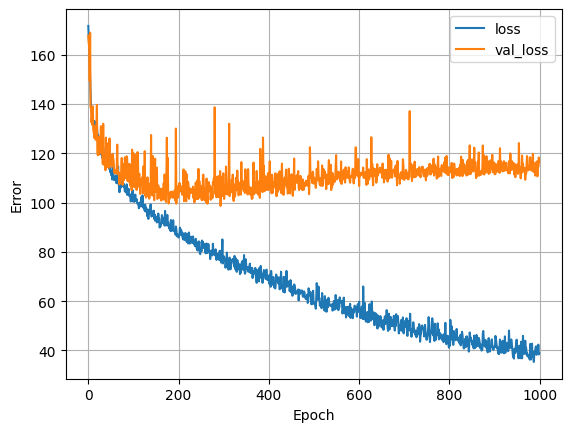

In [44]:
plot_loss(history)

43/43 [==============================] - 0s 563us/step


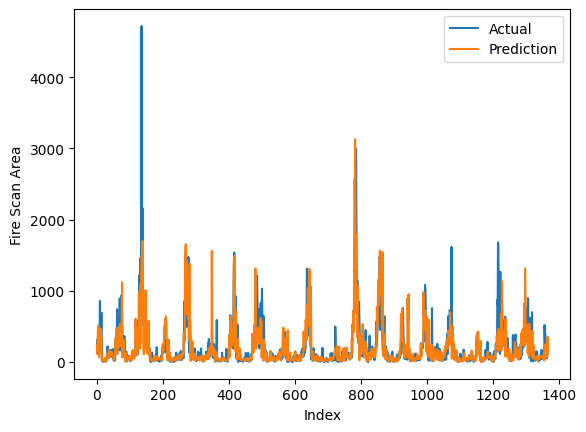

In [45]:
plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.plot(model.predict(test_features), label="Prediction")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()

In [46]:
model.save("../model/model.h5")

model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing to see if loading models works.

43/43 [==============================] - 0s 739us/step


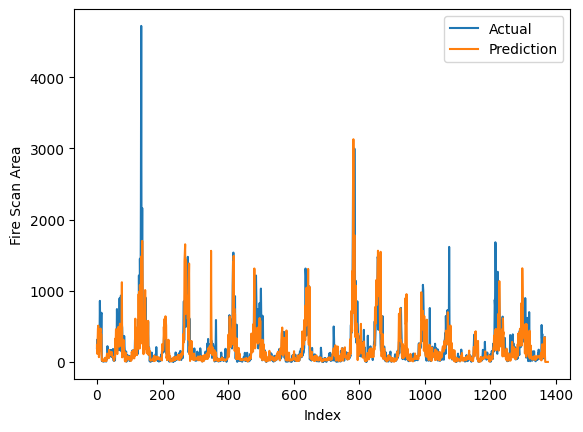

In [47]:
loaded_model = tf.keras.models.load_model("../model/model.h5")

predictions = loaded_model.predict(test_features).to_tensor().numpy().flatten()

plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.plot(predictions, label="Prediction")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()

In [48]:
# testing with some crazy data
new_data = {
    "max_t_syd": [34.023],
    "max_t_bne": [35.253],
    "time_sin": [0.017213],
    "time_cos": [0.999852],
    "year": [20.0]
}

new_df = pd.DataFrame(data=new_data)

loaded_model.predict(new_df)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/dense_22/Tensordot/MatMul' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/joeltan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/4f/zhjjvgx16sl18qcqxczjhqhm0000gn/T/ipykernel_46404/1941428918.py", line 12, in <module>
      loaded_model.predict(new_df)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'sequential_2/dense_22/Tensordot/MatMul'
Matrix size-incompatible: In[0]: [1,5], In[1]: [6,8]
	 [[{{node sequential_2/dense_22/Tensordot/MatMul}}]] [Op:__inference_predict_function_1331205]